# HI Survey

This tutorial goes through the data reduction of position switched observations of the 21 cm HI line. The data used for this tutorial is part of the [New Reference Catalog of Extragalactic HI Observations
](https://greenbankobservatory.org/~koneil/HIsurvey/index.shtml) by [Karen O'Neil](https://greenbankobservatory.org/~koneil/). For more details about how the observations were set up, please refer to the [GBTdocs HI Position Switched (psw) Spectrum tutorial](https://gbtdocs.readthedocs.io/en/latest/tutorials/hi_psw_tutorial.html#) or the [survey article](https://greenbankobservatory.org/~koneil/paps/HIsurvey.html).

Some basic information about the observations. The observations use position switching, and in some cases, the data is recorded without firing a noise diode, so that it is not possible to derive a system temperature from those records alone. In those cases, we will use observations close in time when the noise diodes where fired.

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/hi_survey.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/hi_survey.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [2]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
import numpy as np

# This module is used for custom plotting.
import matplotlib.pyplot as plt

# We will use this module to compare with published results.
import pandas as pd

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [64]:
url = "http://www.gb.nrao.edu/dysh/example_data/hi-survey/data/AGBT04A_008_02.raw.acs/AGBT04A_008_02.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
220,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,185.280583,82.024626
221,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,187.213578,81.998047
222,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,193.833116,81.841281
223,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,195.676641,81.778794
224,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,195.518231,80.291009
225,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,5,1,199.935766,81.600451
226,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,200.833322,80.026463
227,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,205.947060,81.260862
228,B1328+254,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,207.525690,73.984375
229,B1328+254,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,210.959989,75.158373


There is a total of 81 scans in this data set, all used a single spectral window (IF), two polarizations (PLNUM), and a single feed (FDNUM).

## Data Reduction

### Single On/Off Pair
We will start by reducing data for a single pair of position switched scans, which used the noise diodes. We will use scan 270. First, we calibrate the data for a single polarization, `plnum=0`. We use the `getps` method of `GBTFITLoad`, which returns a `ScanBlock`. Since we are calibrating a single pair of position switched scans, the use of a `ScanBlock` won't be evident, but we will see it when we calibrate multiple pairs of observations.

In [6]:
pssb0 = sdfits.getps(scan=270, plnum=0, ifnum=0, fdnum=0)
pssb0

ScanBlock([<dysh.spectra.scan.PSScan at 0x7f2f5d6fc700>])

The return is a `ScanBlock` with a single `PSScan` in it. We can extract information from the observations by querying the different attributes of the `PSScan`, like the system temperature in K (`tsys`), or exposure time in seconds (`exposure`).

In [7]:
pssb0[0].tsys

array([27.17371015, 27.18010156, 27.19215288, 27.16457608, 27.18220045,
       27.18888432, 27.17167504, 27.16475662, 27.15403792, 27.18787308,
       27.1865592 , 27.18108986, 27.16961161, 27.17581517, 27.17490008,
       27.17325784, 27.17196806, 27.17202806, 27.21359808, 27.18930318,
       27.18091661, 27.16828651, 27.17083338, 27.17112253, 27.17606212,
       27.17459134, 27.17332393, 27.21278453, 27.17397878, 27.17012782])

In [8]:
pssb0[0].exposure

array([4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948797,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948785, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948797, 4.77948797, 4.77948809])

In [9]:
pssb0[0].scan

271

In [10]:
pssb0[0].plnum

0

In [11]:
pssb0[0].ifnum

0

Notice that the `PSScan` says it has a scan number (`scan`) of 271. This is because `dysh` can tell that the on-source observation has a scan number of 271, and the off-source observation is in scan 270.

#### Inspecting Individual Integrations

If we want to have a look at the calibrated data, integration by integration, we can use the `_calibrated` attribute of the `PSScan`. This returns an array with rows corresponding to the integrations, and columns to the channel number.

In [12]:
pssb0[0]._calibrated

masked_array(
  data=[[-50.41327667236328, -17.35414695739746, 59.479190826416016, ...,
         -0.05627469718456268, 0.06515730917453766, 0.5484910011291504],
        [24.405393600463867, -32.876129150390625, -0.19761665165424347,
         ..., 0.2878355383872986, 0.6664587259292603, 1.7173004150390625],
        [1.0966312885284424, -20.439929962158203, 6.070507526397705, ...,
         0.19782519340515137, 0.959651529788971, 0.35590970516204834],
        ...,
        [47.206546783447266, -28.20340347290039, -23.154296875, ...,
         -0.8864640593528748, -0.3046358525753021, -2.148747205734253],
        [-148.5045623779297, 46.845848083496094, -49.767757415771484,
         ..., 0.025276966392993927, 0.6366174817085266,
         0.460723340511322],
        [-13.19980239868164, 48.671852111816406, -17.70376968383789, ...,
         -0.8527239561080933, -0.537662148475647, 0.19564472138881683]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ...,

We can also retrieve the calibrated integrations as `Spectrum` objects using the `calibrated` method.

In [13]:
pssb0_int0 = pssb0[0].calibrated(0)
pssb0_int0

<Spectrum1D(flux=[-50.41327667236328 ... 0.5484910011291504] K (shape=(32768,), mean=0.00890 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2004-04-22T07:08:15.000, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (202.68562135, 32.76085866, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 4676.)>
    observer to target (computed from above):
      radial_velocity=4686.132814909312 km / s
      redshift=0.0157553569969906
    doppler_rest=1420405400.0 Hz
    doppler_convention=optical)
  [1.39229407e+09 1.39229445e+09 1.39229483e+09 ... 1.40479293e+09
 1.40479331e+09 1.40479369e+09] Hz> (length=32768))>

`Spectrum` objects have a variety of methods, such as `plot`, `smooth`, and `baseline`. Here we use `plot` to look a the data.

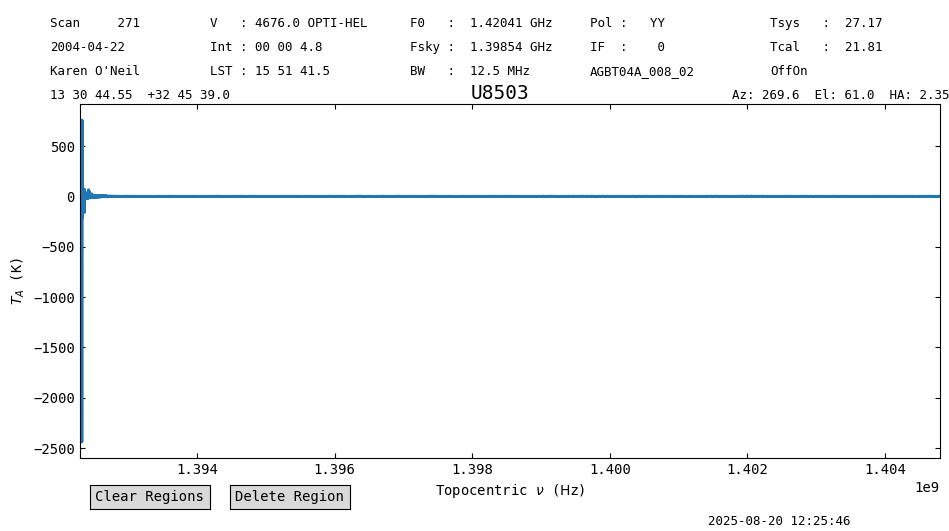

In [14]:
pssb0_int0.plot()

The y-axis can be adjusted during the call to `plot`, through the `ymin` and `ymax` arguments.

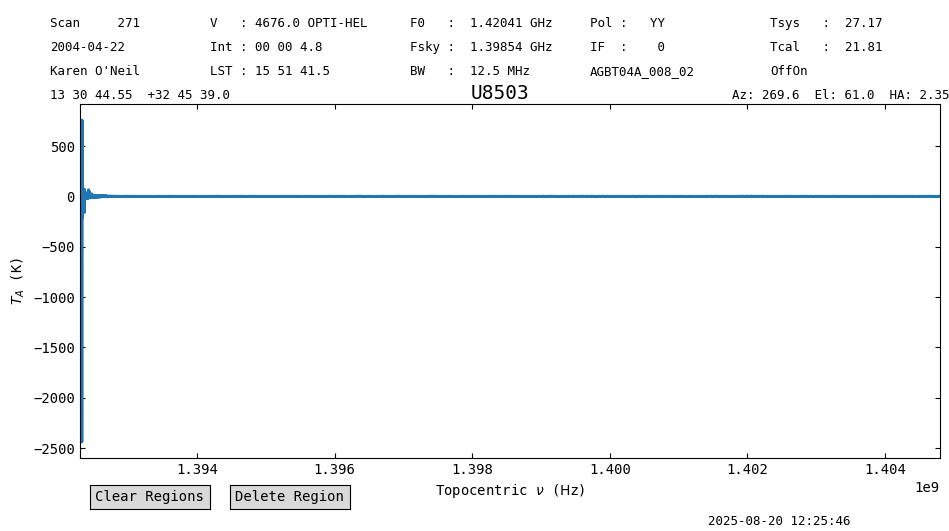

In [15]:
pssb0_int0.plot(ymin=-5, ymax=5)

Since this is a single integration, there's not much to see. Let's work on a time average now.

#### Time Averaging Integrations

Time averaging can be done using the `timeaverage` method of a `Scan` or `ScanBlock`. By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

`timeaverage` will return a `Spectrum` object.

In [16]:
ps0_spec = pssb0.timeaverage()
ps0_spec

<Spectrum1D(flux=[-20.559832239193426 ... 0.06326033900588074] K (shape=(32768,), mean=0.15409 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2004-04-22T07:08:15.000, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (202.68562135, 32.76085866, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 4676.)>
    observer to target (computed from above):
      radial_velocity=4686.132814909312 km / s
      redshift=0.0157553569969906
    doppler_rest=1420405400.0 Hz
    doppler_convention=optical)
  [1.39229407e+09 1.39229445e+09 1.39229483e+09 ... 1.40479293e+09
 1.40479331e+09 1.40479369e+09] Hz> (length=32768))>

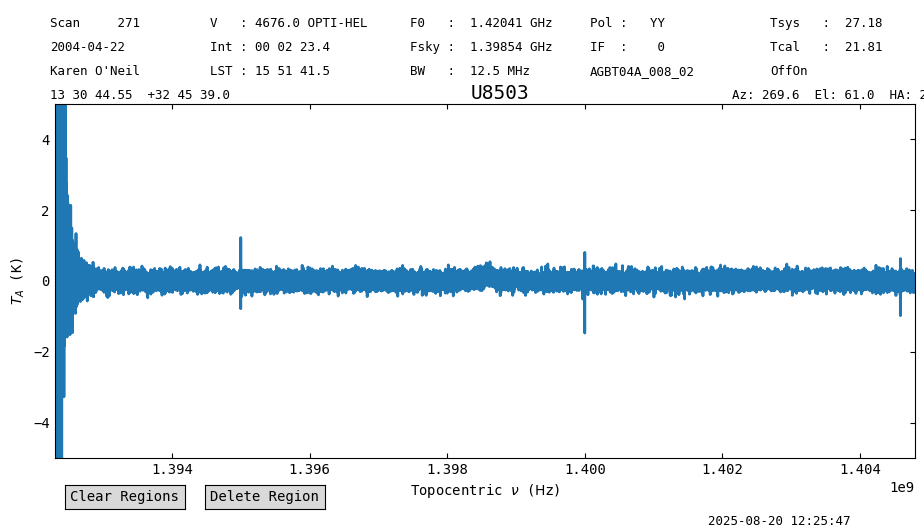

In [17]:
ps0_spec.plot(ymin=-5, ymax=5)

The noise is lower, and there are hints of a signal. Let's smooth the data to further reduce the noise. 

#### Smoothing

Smoothing is done with the `smooth` method. By default it decimates the spectrum, so it only retains independent samples. In this case we smooth using a Gaussian kernel with a width of 16 channels.

In [18]:
ps0_spec_smo = ps0_spec.smooth("gauss", 16)

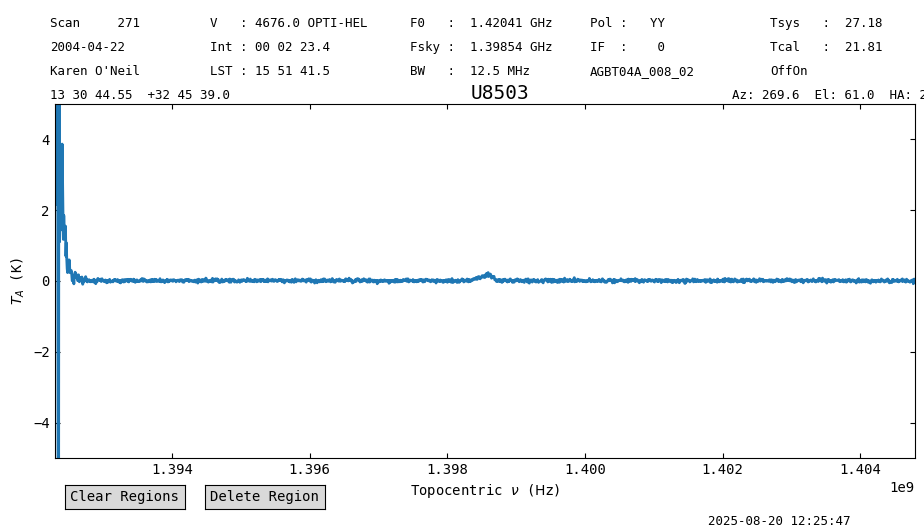

In [19]:
ps0_spec_smo.plot(ymin=-5, ymax=5)

We have to zoom in further to see the signal. We also limit the x-axis range.

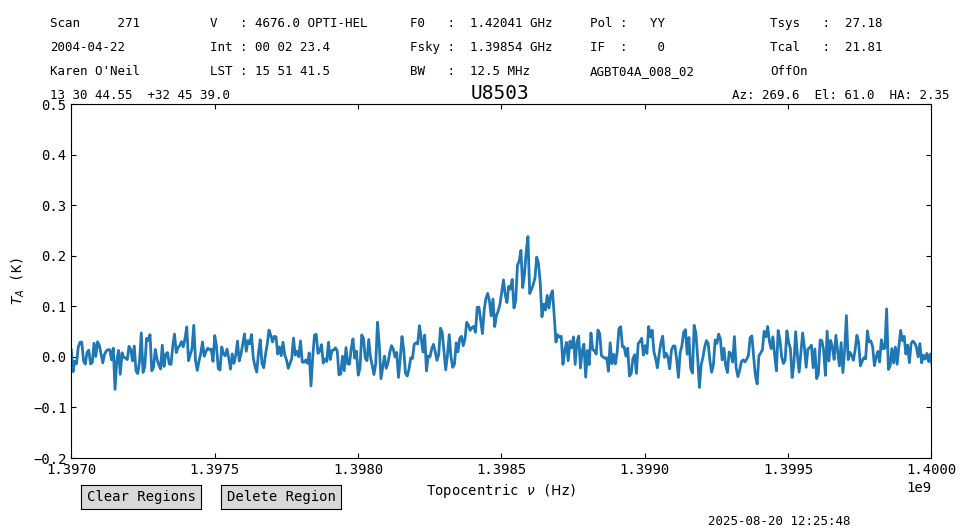

In [20]:
ps0_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

#### Polarization Averaging

While inspecting the data we saw that there are two polarizations. We can average them together to further reduce the noise by a factor $\sqrt{2}$. The second polarization can be calibrated following the above steps, but setting `plnum=1`. Here we also demonstrate the use of chaining to do the data reduction. This refers to using multiple commands in a chain, like

In [21]:
ps1_spec_smo = sdfits.getps(scan=270, plnum=1, ifnum=0, fdnum=0).timeaverage().smooth("gauss", 16)

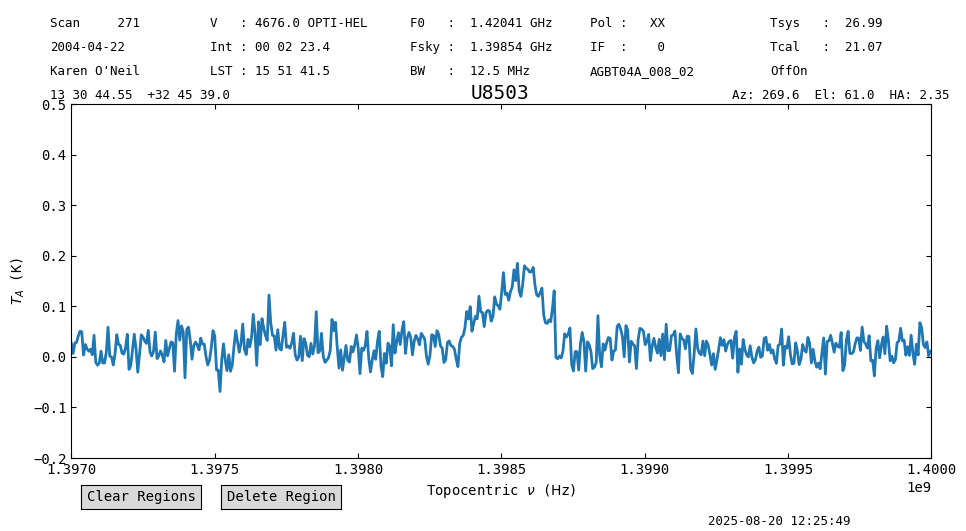

In [22]:
ps1_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

Now we average the smoothed spectra for both polarizations using the `average` method.

In [23]:
ps_spec_smo = ps0_spec_smo.average([ps1_spec_smo])

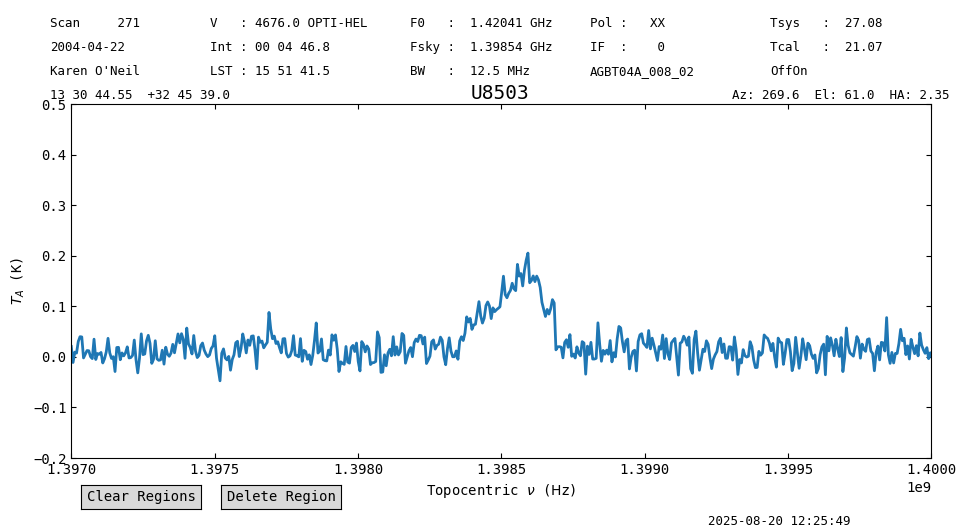

In [24]:
ps_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

#### Statistics

Now we will compare the noise properties of the spectra. For this we leverage the ability to slice spectra. First, we replot the spectra over the whole x-range to find a good frequency range where to compute statistics.

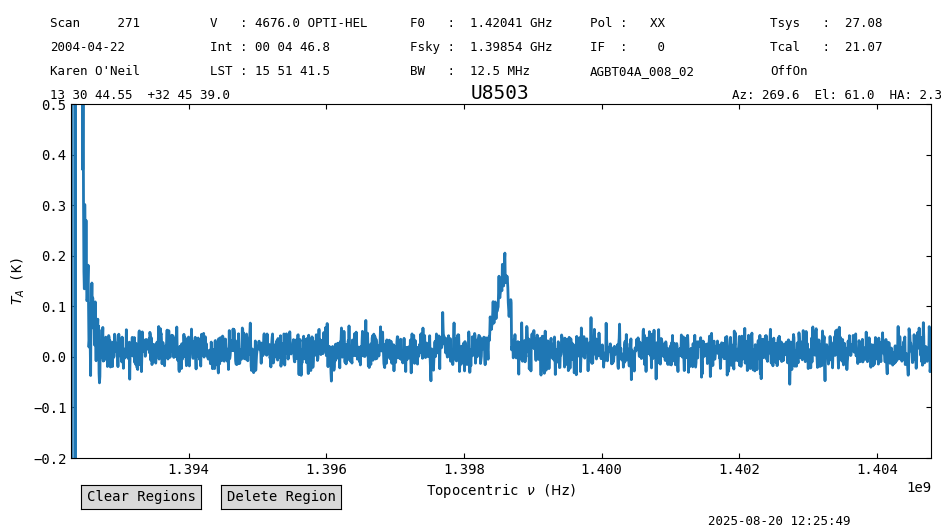

In [25]:
ps_spec_smo.plotter.reset()
ps_spec_smo.plot(ymin=-0.2, ymax=0.5)

We use the range between 1394 MHz and 1398 MHz, and then compute the statistics over this range.

In [26]:
s = slice(1394*u.MHz, 1398*u.MHz)
ps_spec_smo[s].stats()

{'mean': <Quantity 0.0138139 K>,
 'median': <Quantity 0.01388117 K>,
 'rms': <Quantity 0.0202041 K>,
 'min': <Quantity -0.04793606 K>,
 'max': <Quantity 0.0878015 K>}

Now for the individual polarizations.

In [27]:
ps0_spec_smo[s].stats(), ps1_spec_smo[s].stats()

({'mean': <Quantity 0.00952572 K>,
  'median': <Quantity 0.00854112 K>,
  'rms': <Quantity 0.02516344 K>,
  'min': <Quantity -0.07801185 K>,
  'max': <Quantity 0.08209355 K>},
 {'mean': <Quantity 0.01804343 K>,
  'median': <Quantity 0.01677582 K>,
  'rms': <Quantity 0.02622516 K>,
  'min': <Quantity -0.06849154 K>,
  'max': <Quantity 0.12214609 K>})

The individual polarizations had an rms of $\approx0.0255$ K, and the average an rms of $0.02$ K. Thus, the average has a noise a factor of $0.9\sqrt{2}$ lower than the individual polarizations. That is $10\%$ higher than expected.

#### Baseline Subtraction

Now we will subtract a baseline from the averaged spectrum. For this we use the `baseline` method. It is important to use a range of frequencies that will not bias the baseline fit. We exclude the range at the low-frequency end of the spectral window, up to 1394 MHz, and the range that contains the spectral line, between 1398 and 1400 MHz. In this case we use a polynomial of order 1 as our baseline model.

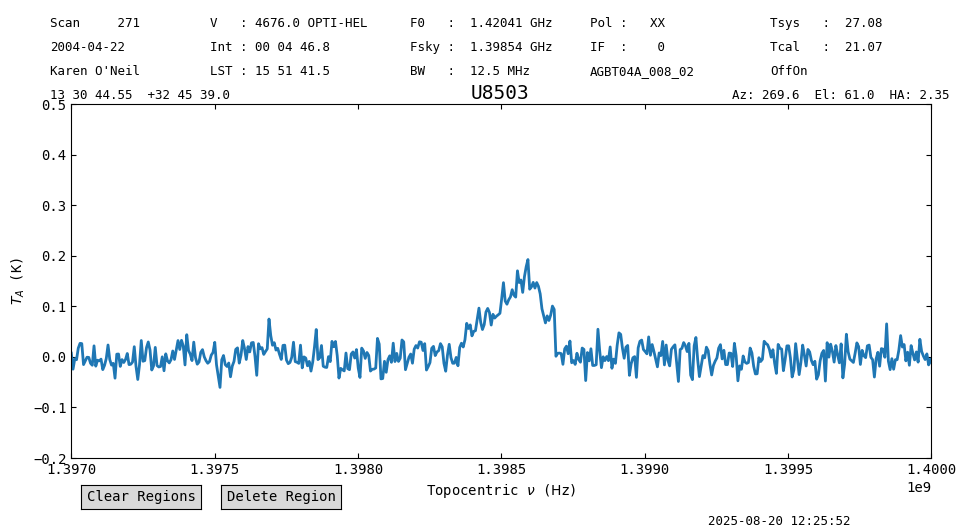

In [28]:
exclude = [(1*u.GHz,1.394*u.GHz),(1.398*u.GHz,1.4*u.GHz)]
ps_spec_smo.baseline(1, model="poly", exclude=exclude, remove=True)
ps_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

In [29]:
ps_spec_smo[s].stats()

{'mean': <Quantity 0.0003344 K>,
 'median': <Quantity 0.00017338 K>,
 'rms': <Quantity 0.02020542 K>,
 'min': <Quantity -0.06139418 K>,
 'max': <Quantity 0.07479668 K>}

The mean and median are closer to zero now.

### Multiple On/Off Pairs

Now that we understand how to process a single pair of On/Off scans, we proceed to calibrate a bunch of them. In `dysh` this can be accomplished by either, giving a list of scans to the calibration routines, or by selecting the scans based on another property of the data. 

#### Using a List of Scans

First we need to figure out all of the scans for a particular source. For U8503, there is a single pair of On/Off scans, so we need to use a different source. We use 3C286, for which we have scans 220, 221, 222, 223, 224, 225, 226, 227 using OffOn with the noise diodes. 

We could have figured out which scans using:

In [30]:
scan_list = list(set(sdfits["SCAN"][(sdfits["OBJECT"] == "3C286") & \
                     (sdfits["PROC"] == "OffOn") & (sdfits["CAL"] == "T")]))
sorted(scan_list)

[220, 221, 222, 223, 224, 225, 226, 227]

In [31]:
ps0_obj = sdfits.getps(scan=scan_list, plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_obj = sdfits.getps(scan=scan_list, plnum=1, ifnum=0, fdnum=0).timeaverage()
ps_obj = ps0_obj.average(ps1_obj)

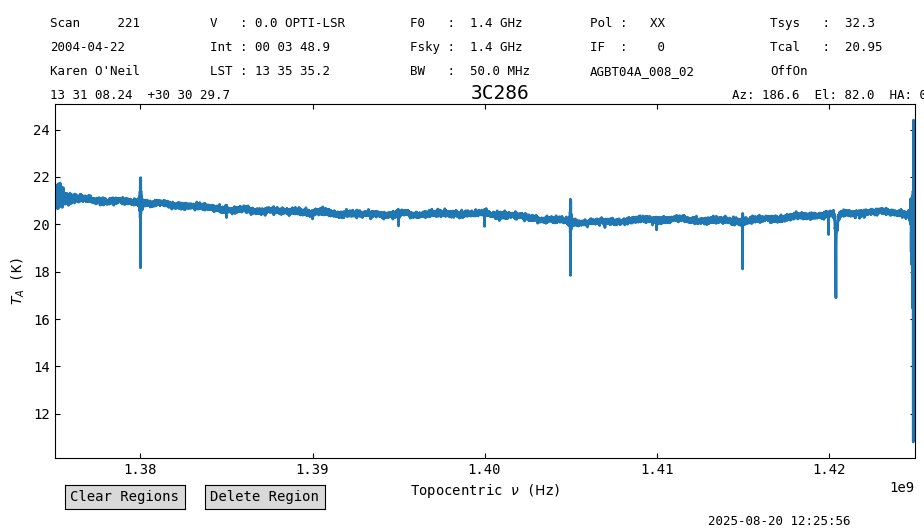

In [32]:
ps_obj.plot()

Since 3C286 is a continuum source, we can see Galactic HI absorption against the continuum.

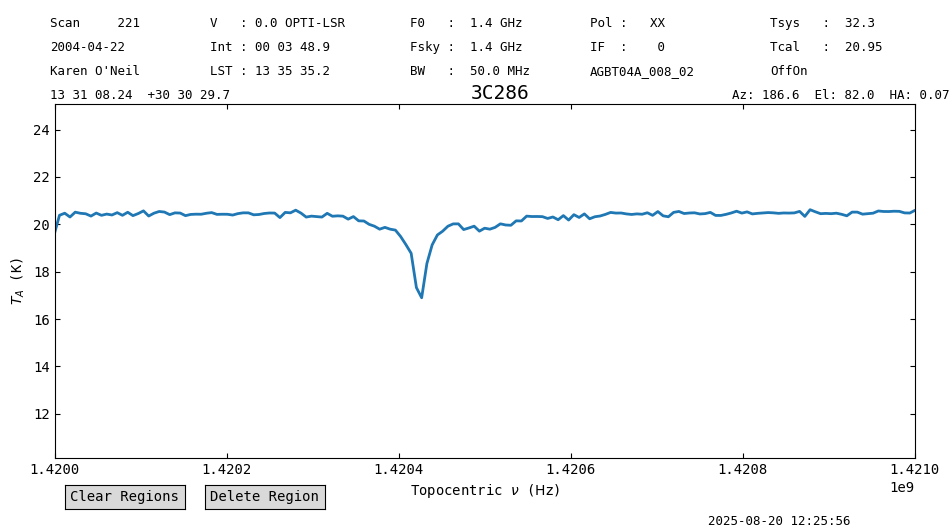

In [33]:
ps_obj.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

#### Using Selection

We can do the same by using the `selection` method before calling `getps`.

In [34]:
sdfits.select(object="3C286", proc="OffOn")
ps0_obj_b = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_obj_b = sdfits.getps(plnum=1, ifnum=0, fdnum=0).timeaverage()
ps_obj_b = ps0_obj_b.average(ps1_obj_b)

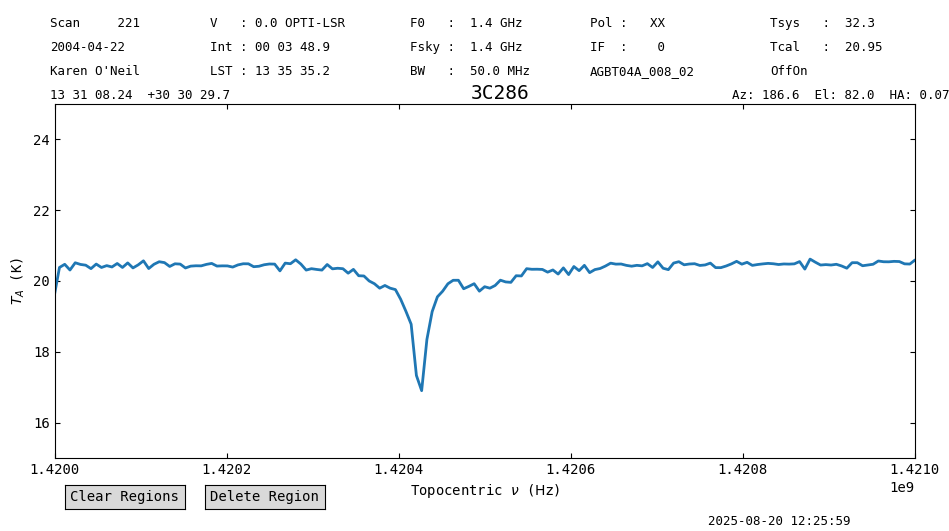

In [35]:
ps_obj_b.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

Once you are done calibrating, you should clear the selection to have access to all the data again.

In [36]:
sdfits.selection.clear()

#### Using Arguments

We can accomplish the same by specifying the `object` and procedure type (`proc`) during the call to `getps`. Any of the calibration methods (`getps`, `getfs`, `getnod`, `getsigref`, `getsubbeamnod`, `getsigref`) can take as argument any of the [columns of an SDFITS file](https://dysh.readthedocs.io/en/latest/reference/sdfits_files/gbt_sdfits.html#data). When used this way, the calibration routine will only use the data that satiosfies the conditions, so for example, if we use `sdfits.getps(object="3C286", plnum=0, ifnum=0, fdnum=0)` the calibration routine will only use data that has the column "OBJECT" equal to "3C286".

Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.


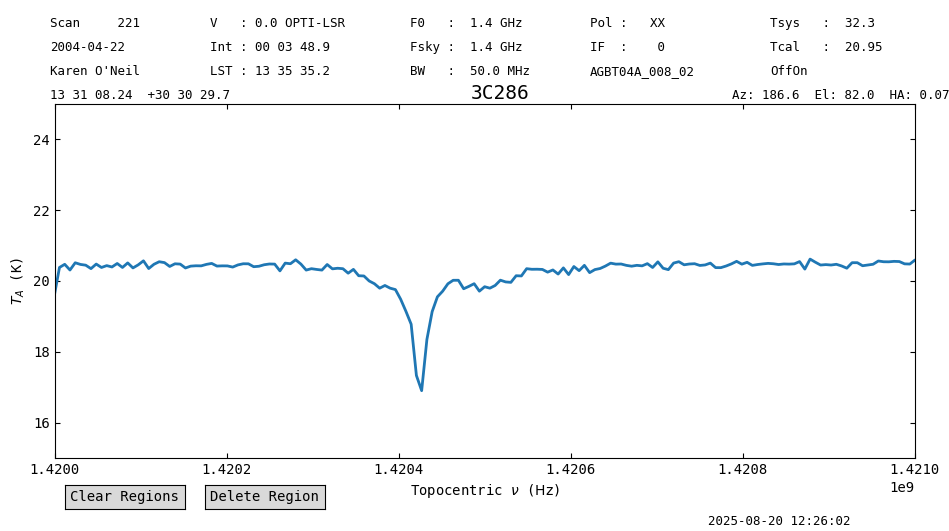

In [37]:
ps0_obj_c = sdfits.getps(plnum=0, ifnum=0, fdnum=0, object="3C286", proc="OffOn").timeaverage()
ps1_obj_c = sdfits.getps(plnum=1, ifnum=0, fdnum=0, object="3C286", proc="OffOn").timeaverage()
ps_obj_c = ps0_obj_c.average(ps1_obj_c)
ps_obj_c.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

### Calibration Without Noise Diodes

Most of the scans in this example did not use the noise diode. In this case we need to provide a value for the system temperature so that the data can be calibrated. For this particular observation, there is one Track observing procedure associated with the OffOn pairs. For these Track observations, the noise diode was fired, so we can use them to figure out the system temperature.

We will work on observations of U11627. For this source the Track scan is 320, and the OffOn pairs are in scans 316, 317, 318 and 319.

First we use `gettp` to figure out the system temperature from the Track scan.

In [38]:
tp0 = sdfits.gettp(scan=320, plnum=0, ifnum=0, fdnum=0).timeaverage()
tp1 = sdfits.gettp(scan=320, plnum=1, ifnum=0, fdnum=0).timeaverage()

The system temperature is stored in the `meta` dictionary of each `Spectrum`.

In [39]:
print(f"System temperature for plnum={tp0.meta['PLNUM']}: {tp0.meta['TSYS']:.2f} K")
print(f"System temperature for plnum={tp1.meta['PLNUM']}: {tp1.meta['TSYS']:.2f} K")

System temperature for plnum=0: 28.05 K
System temperature for plnum=1: 27.65 K


Now we use these values to calibrate the data. The system temperature is provided for the calibration methods through the `t_sys` argument. It is assumed to be in K.

In [40]:
sdfits.select(object="U11627", proc="OffOn")
ps0_wtsys = sdfits.getps(plnum=0, ifnum=0, fdnum=0, t_sys=tp0.meta['TSYS']).timeaverage()
ps1_wtsys = sdfits.getps(plnum=1, ifnum=0, fdnum=0, t_sys=tp1.meta['TSYS']).timeaverage()
ps_wtsys = ps0_wtsys.average(ps1_wtsys)

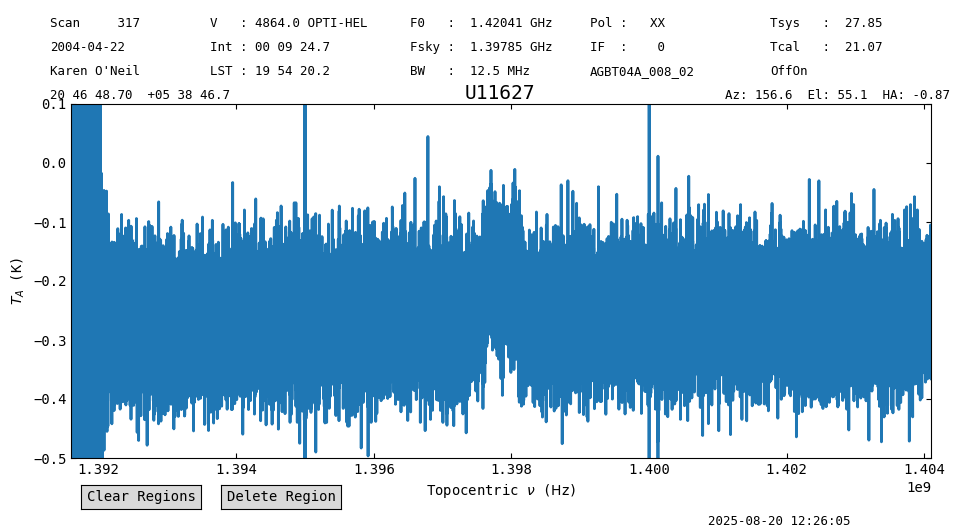

In [41]:
ps_wtsys.plot(ymin=-0.5, ymax=0.1)

Now we smooth and remove a baseline.

In [42]:
ps_wtsys_smo = ps_wtsys.smooth("gauss", 16)
ps_wtsys_smo.baseline(1, model="poly", exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], remove=True)

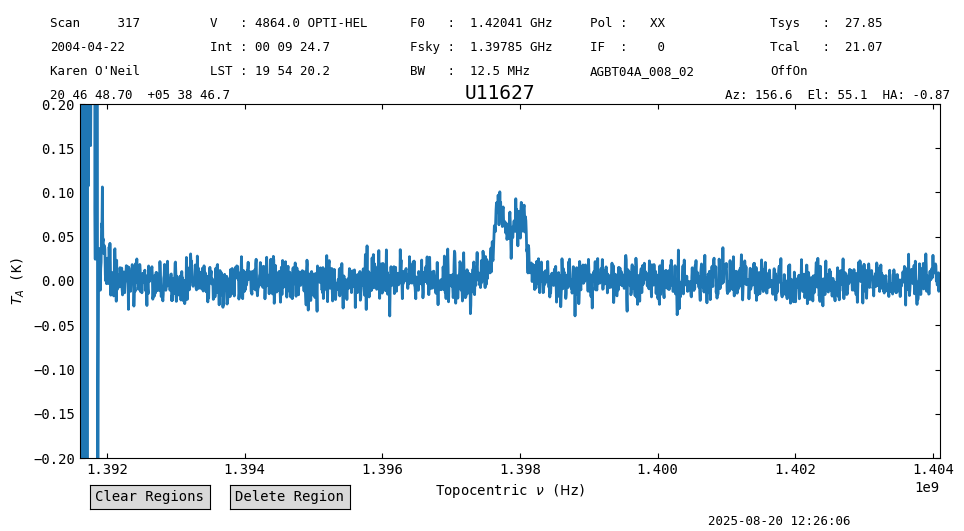

In [43]:
ps_wtsys_smo.plot(ymin=-0.2, ymax=0.2)

In [44]:
sdfits.selection.clear()

### Combining Off Spectra

In some situations we would like to have more flexibility during calibration to specify what will be the Off or reference spectrum used for calibration. In these cases we can use the `GBTFITSLoad.getsigref` function. This function takes as inputs a scan number, or list of them, to be used as On, and a reference spectrum, or scan number (only one in this case). Here we will combine the two Off source spectra from the previous calibration before calibrating the data.

We use `GBTFITSLoad.gettp` to produce the reference spectrum.

In [45]:
tp_ref0 = sdfits.gettp(scan=[316,318], plnum=0, ifnum=0, fdnum=0, t_sys=tp0.meta['TSYS']).timeaverage()
tp_ref1 = sdfits.gettp(scan=[316,318], plnum=1, ifnum=0, fdnum=0, t_sys=tp1.meta['TSYS']).timeaverage()

Now use `GBTFITSLoad.getsigref` to do the calibration. Since we specified the system temperature in the previous call to `gettp`, we do not need to provide it again.

In [46]:
sdfits.select(object="U11627", proc="OffOn")
ps0_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref0, plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref1, plnum=1, ifnum=0, fdnum=0).timeaverage()

Average both polarizations, smooth and remove a baseline like before so we can compare the results.

In [47]:
ps_wtsys_tpr = ps0_wtsys_tpr.average(ps1_wtsys_tpr)
ps_wtsys_tpr_smo = ps_wtsys_tpr.smooth("gauss", 16)
ps_wtsys_tpr_smo.baseline(1, model="poly", 
                          exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], 
                          remove=True)

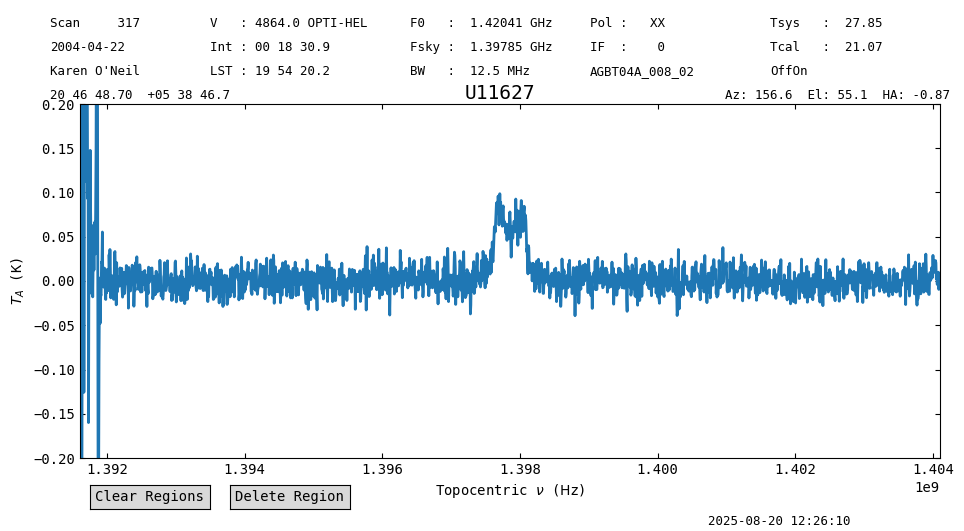

In [48]:
ps_wtsys_tpr_smo.plot(ymin=-0.2, ymax=0.2)

Now compare the noise in the end products.

In [49]:
s = slice(1.393*u.GHz, 1.396*u.GHz)
rms_tpr = ps_wtsys_tpr_smo[s].stats()["rms"]
rms = ps_wtsys_smo[s].stats()["rms"]
print(f"Ratio of rms: {rms_tpr/rms}")

Ratio of rms: 0.9997997985702746


In this case, using a combined reference spectrum improved the noise by an insignificant amount, $\approx0.02\%$.

### Working in Flux Units

So far we have calibrated the data to antenna temperature units, but it is also possible to work on flux units. To do so, we must provide a zenith opacity value and specify that we want the data in Jy, using the `zenith_opacity` and `bunit` parameters. Since this data is observed at 1.4 GHz, we use a small value for the zenith opacity, 0.08. For more details on how to find the zenith opacity for your observations, please see [this guide](https://gbtdocs.readthedocs.io/en/latest/how-tos/data_reduction/calculate_opacity.html). We also repeat the previous calibration steps.

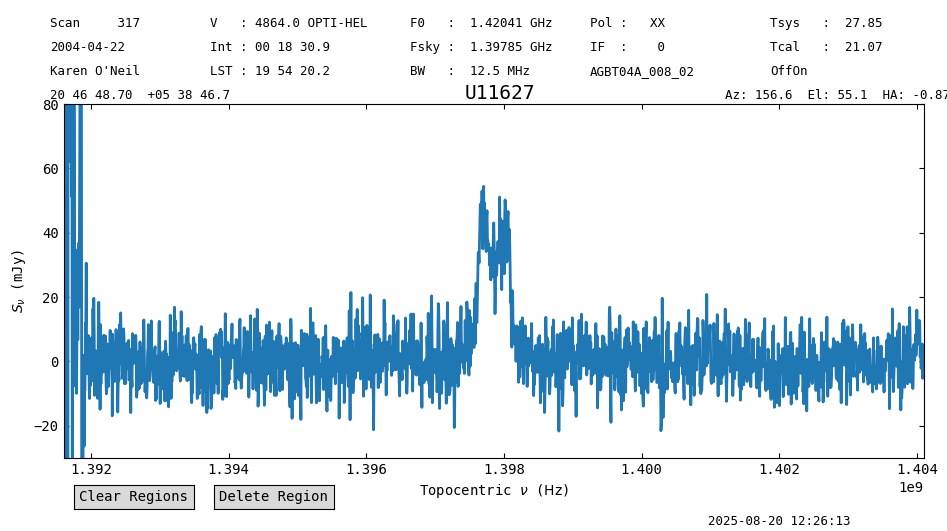

In [50]:
ps0_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref0, plnum=0, ifnum=0, fdnum=0, 
                                 bunit="jy", zenith_opacity=0.08).timeaverage()
ps1_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref1, plnum=1, ifnum=0, fdnum=0, 
                                 bunit="jy", zenith_opacity=0.08).timeaverage()
ps_wtsys_tpr = ps0_wtsys_tpr.average(ps1_wtsys_tpr)
ps_wtsys_tpr_smo = ps_wtsys_tpr.smooth("gauss", 16)
ps_wtsys_tpr_smo.baseline(1, model="poly", 
                          exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], 
                          remove=True)
ps_wtsys_tpr_smo.plot(ymin=-30, ymax=80, yaxis_unit="mJy")

## Measuring Line Properties

`Spectrum` objects provide a convenience function for analysis of HI profiles based on the Curve of Growth (CoG) method by [Yu et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...898..102Y/abstract). The implementation of this method can retrieve line parameters in a fully automated way, however, this is likely to work only in high signal-to-noise cases (>10). In low signal-to-noise cases, additional inputs are required to aid the method. In particular, it helps to provide a good estimate of the central velocity of the line using the `vc` parameter and/or restricting the range over which the method is applied, either by slicing the `Spectrum` or using the `bchan` and `echan` parameters.

First we apply the method blindly, ignoring the edge channels.

In [51]:
line_props = ps_wtsys_tpr_smo[60:-60].cog()
line_props

{'flux': <Quantity 4.92013542 Jy km / s>,
 'flux_std': <Quantity 0.22674158 Jy km / s>,
 'flux_r': <Quantity 0.64844634 Jy km / s>,
 'flux_r_std': <Quantity 0.12568651 Jy km / s>,
 'flux_b': <Quantity 4.21256431 Jy km / s>,
 'flux_b_std': <Quantity 0.14854346 Jy km / s>,
 'width': {0.25: <Quantity 20.95960416 km / s>,
  0.65: <Quantity 71.53636764 km / s>,
  0.75: <Quantity 86.1801435 km / s>,
  0.85: <Quantity 98.16246145 km / s>,
  0.95: <Quantity 142.10568952 km / s>},
 'width_std': {0.25: <Quantity 1.33075238 km / s>,
  0.65: <Quantity 5.32484658 km / s>,
  0.75: <Quantity 5.32535833 km / s>,
  0.85: <Quantity 9.32023205 km / s>,
  0.95: <Quantity 27.9653384 km / s>},
 'A_F': 6.496396160996771,
 'A_C': 3.3128525690353294,
 'C_C': 4.683411990302724,
 'rms': <Quantity 0.00676331 Jy>,
 'bchan': 712,
 'echan': 1140,
 'vel': <Quantity 4887.77671788 km / s>,
 'vel_std': <Quantity 602.5231022 km / s>}

Plot the results along with the central velocity and the line width that encompasses 95% of the total flux.

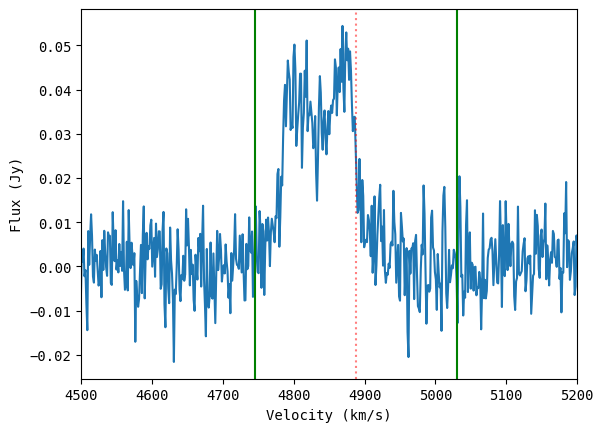

In [52]:
plt.figure()
plt.plot(ps_wtsys_tpr_smo[60:].spectral_axis.to("km/s"), ps_wtsys_tpr_smo[60:].flux)
plt.axvline(line_props["vel"].value, c="r", alpha=0.5, ls=":")
plt.axvline((line_props["vel"] - line_props["width"][0.95]).value, c="g")
plt.axvline((line_props["vel"] + line_props["width"][0.95]).value, c="g")
plt.xlim(4500, 5200)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (Jy)");

The results are not great. Use CoG again, but providing a range of channels through the `bchan` and `echan` parameters (these can only be channel numbers).

In [53]:
line_props_wrange = ps_wtsys_tpr_smo[60:-60].cog(bchan=line_props["bchan"], echan=line_props["echan"])
line_props_wrange

{'flux': <Quantity 4.62252663 Jy km / s>,
 'flux_std': <Quantity 0.07770949 Jy km / s>,
 'flux_r': <Quantity 2.60816402 Jy km / s>,
 'flux_r_std': <Quantity 0.04971888 Jy km / s>,
 'flux_b': <Quantity 2.0422127 Jy km / s>,
 'flux_b_std': <Quantity 0.05304374 Jy km / s>,
 'width': {0.25: <Quantity 15.59303656 km / s>,
  0.65: <Quantity 39.53852622 km / s>,
  0.75: <Quantity 46.1907192 km / s>,
  0.85: <Quantity 54.17373424 km / s>,
  0.95: <Quantity 68.81034841 km / s>},
 'width_std': {0.25: <Quantity 1.33020623 km / s>,
  0.65: <Quantity 1.33041536 km / s>,
  0.75: <Quantity 1.33046184 km / s>,
  0.85: <Quantity 1.33054318 km / s>,
  0.95: <Quantity 1.32781642 km / s>},
 'A_F': 1.277126530772413,
 'A_C': 1.0656556638708854,
 'C_C': 3.4742260774523217,
 'rms': <Quantity 0.00677671 Jy>,
 'bchan': 712,
 'echan': 1140,
 'vel': <Quantity 4830.61103241 km / s>,
 'vel_std': <Quantity 270.71838549 km / s>}

In [54]:
line_props_wrange = ps_wtsys_tpr_smo[60:-60].cog(bchan=750, echan=1100)
line_props_wrange

{'flux': <Quantity 4.65441734 Jy km / s>,
 'flux_std': <Quantity 0.03760494 Jy km / s>,
 'flux_r': <Quantity 2.42427805 Jy km / s>,
 'flux_r_std': <Quantity 0.05210829 Jy km / s>,
 'flux_b': <Quantity 2.21290064 Jy km / s>,
 'flux_b_std': <Quantity 0.03704703 Jy km / s>,
 'width': {0.25: <Quantity 17.33872796 km / s>,
  0.65: <Quantity 39.95499896 km / s>,
  0.75: <Quantity 45.2769625 km / s>,
  0.85: <Quantity 53.26025644 km / s>,
  0.95: <Quantity 78.54344755 km / s>},
 'width_std': {0.25: <Quantity 1.32780484 km / s>,
  0.65: <Quantity 1.32800181 km / s>,
  0.75: <Quantity 1.32804816 km / s>,
  0.85: <Quantity 1.33058967 km / s>,
  0.95: <Quantity 5.32312578 km / s>},
 'A_F': 1.0955205150196814,
 'A_C': 1.0731923450658685,
 'C_C': 3.0717510858904897,
 'rms': <Quantity 0.00677063 Jy>,
 'bchan': 750,
 'echan': 1100,
 'vel': <Quantity 4836.84675265 km / s>,
 'vel_std': <Quantity 247.00045709 km / s>}

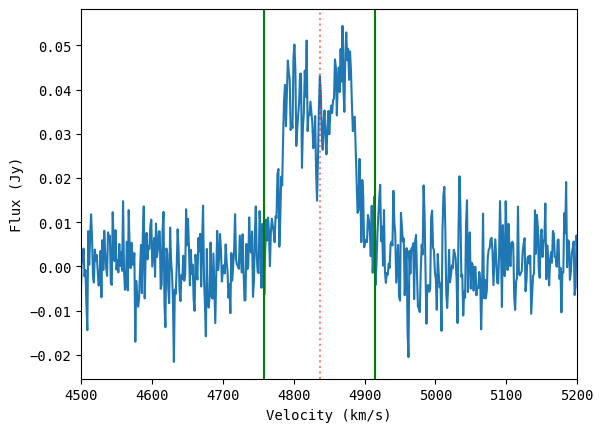

In [55]:
plt.figure()
plt.plot(ps_wtsys_tpr_smo[60:].spectral_axis.to("km/s"), ps_wtsys_tpr_smo[60:].flux)
plt.axvline(line_props_wrange["vel"].value, c="r", alpha=0.5, ls=":")
plt.axvline((line_props_wrange["vel"] - line_props_wrange["width"][0.95]).value, c="g")
plt.axvline((line_props_wrange["vel"] + line_props_wrange["width"][0.95]).value, c="g")
plt.xlim(4500, 5200)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (Jy)");

Much better!

## Putting it all Together

Now we can use what we have learned to process all of the observations.
We will loop over all the objects, calibrating the data.
For the system temperature, we use the last Track observation associated with a given object.
Since there may have been issues with the previous Track observations if they had to be repeated (for example, for U11578 the first Track observation did not fire the noise diode).
We process "U8503" individually, because there is no "Track" scan for it but the OffOn observations did use the noise diode.

We put all the steps in a function, `process`. This makes it easier to reuse the code, and modify it.

In [56]:
def process(sdfits, object, results, track=True):
    """
    Function to calibrate the AGBT04A_008_02 observations.
    This function was heavily tailored to work with this
    observations and there is no guarantee it would work with
    other data.
    """
    
    o = object

    if track:
        # Use only the last Track observation for every object.
        tp0 = sdfits.gettp(ifnum=0, plnum=0, fdnum=0, object=o, proc="Track")[-1].timeaverage()
        tp1 = sdfits.gettp(ifnum=0, plnum=1, fdnum=0, object=o, proc="Track")[-1].timeaverage()
    
        # Calibrate using the system temperature of the Track scan.
        ps0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, object=o, proc="OffOn", 
                           t_sys=tp0.meta["TSYS"], bunit="jy", zenith_opacity=0.08).timeaverage()
        ps1 = sdfits.getps(ifnum=0, plnum=1, fdnum=0, object=o, proc="OffOn", 
                           t_sys=tp1.meta["TSYS"], bunit="jy", zenith_opacity=0.08).timeaverage()

    else:
        # Calibrate computing the system temperature from the Off scan.
        ps0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, object=o, proc="OffOn", 
                           bunit="jy", zenith_opacity=0.08).timeaverage()
        ps1 = sdfits.getps(ifnum=0, plnum=1, fdnum=0, object=o, proc="OffOn", 
                           bunit="jy", zenith_opacity=0.08).timeaverage()

    # Average polarizations.
    ps = ps0.average(ps1)

    # Smooth.
    ps_smo = ps.smooth("gauss", 16)

    # Determine if the Galactic HI line is present, and if so,
    # ignore it during the baseline fit.
    idx0 = np.argmin(abs(ps_smo.spectral_axis - 1.420*u.GHz))
    idxf = np.argmin(abs(ps_smo.spectral_axis - 1.421*u.GHz))
    idx0,idxf = np.sort([idx0,idxf])
    if idx0 == 0 or idx0 == len(ps_smo.data) - 1 or idxf == 0 or idxf == len(ps_smo.data) - 1:
        exclude=[(0,100),(500,1250),(2047-100,2047)]
    else:
        exclude=[(0,100),(500,1250),(idx0,idxf),(2047-100,2047)]

    # Baseline subtraction.
    ps_smo.baseline(degree=1, model="poly", exclude=exclude, remove=True)

    # Measure line properties using Curve of Growth.
    # Ignore 100 channels in each edge, and compute the
    # CoG over the inner (750,1250) channels.
    cog = ps_smo[100:-100].cog(bchan=750, echan=1250, width_frac=[0.5])

    # Save the measured line properties.
    # In particular, the object name, flux and its width.
    results["name"].append(o.replace("U", "UGC "))
    for k in ["flux", "flux_error"]:
        results[k].append(cog[k.replace("error", "std")].to("Jy km/s").value)
    for k in ["width", "width_error"]:
        results[k].append(cog[k.replace("error", "std")][0.5].to("km/s").value)

measured = {"name": [],
            "flux": [],
            "flux_error": [],
            "width": [],
            "width_error": [],
           }

sdfits.selection.clear()
# Start at object 4 since the previous ones were calibration observations.
for o in sdfits.udata("OBJECT")[4:]:

    if o ==  "U8503":
        track = False
    else:
        track = True
    
    process(sdfits, o, measured, track=track)


Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON 

### Compare with the Literature

We can compare the results obtained here with those listed by the author in [this page](https://greenbankobservatory.org/~koneil/HIsurvey/results_all.html). The results are also provided as a text table. We download this table and parse its contents. We save the flux and W50 values.

In [57]:
table_file = from_url("https://greenbankobservatory.org/~koneil/HIsurvey/results_all.dat", savepath)

In [58]:
data = {"name": [],
        "flux": [],
        "flux_error": [],
        "width": [],
        "width_error": []
       }

with open(table_file) as f:
    lines = f.readlines()
    for line in lines:
        if line.lstrip().startswith("\\"):
            continue
        l = line.split()
        data["name"].append(" ".join(l[:2]))
        if len(l) == 28:
            fcol = 10
        else:
            fcol = 11
        data["flux"].append(float(l[fcol]))
        data["flux_error"].append(float(l[fcol+1]))
        data["width"].append(float(l[fcol+4]))
        data["width_error"].append(float(l[fcol+5]))

Now create `pandas.DataFrame` objects to manipulate the measured and literature results. We use `DataFrame` as it provides a convenient way of handling the data. While loading the data, we sort it by "name". We will also remove sources that do not appear in both data sets.

In [59]:
# Load and sort.
df_obs = pd.DataFrame.from_dict(measured).sort_values(by="name")
df_lit = pd.DataFrame.from_dict(data).sort_values(by="name")

# Find sources present in both data sets.
shared_names = set(df_obs["name"]) & set(df_lit["name"])

# Keep only the sources found above.
df_obs_s = df_obs[df_obs["name"].isin(shared_names)]
df_lit_s = df_lit[df_lit["name"].isin(shared_names)]

For example, for object 11627 the flux is $2.3\pm0.0$ Jy km s$^{-1}$.

In [60]:
# With Pandas.
print(df_lit_s.loc[df_lit_s["name"] == "UGC 11627"])

print("\n") # Blank line.

# Without Pandas.
idx = data["name"].index("UGC 11627")
print(f"Flux for UGC 11627: {data['flux'][idx]} +- {data['flux_error'][idx]} Jy km/s")

         name  flux  flux_error  width  width_error
94  UGC 11627   2.3         0.0  118.0          6.0


Flux for UGC 11627: 2.3 +- 0.0 Jy km/s


Now that we have the results, plot them.

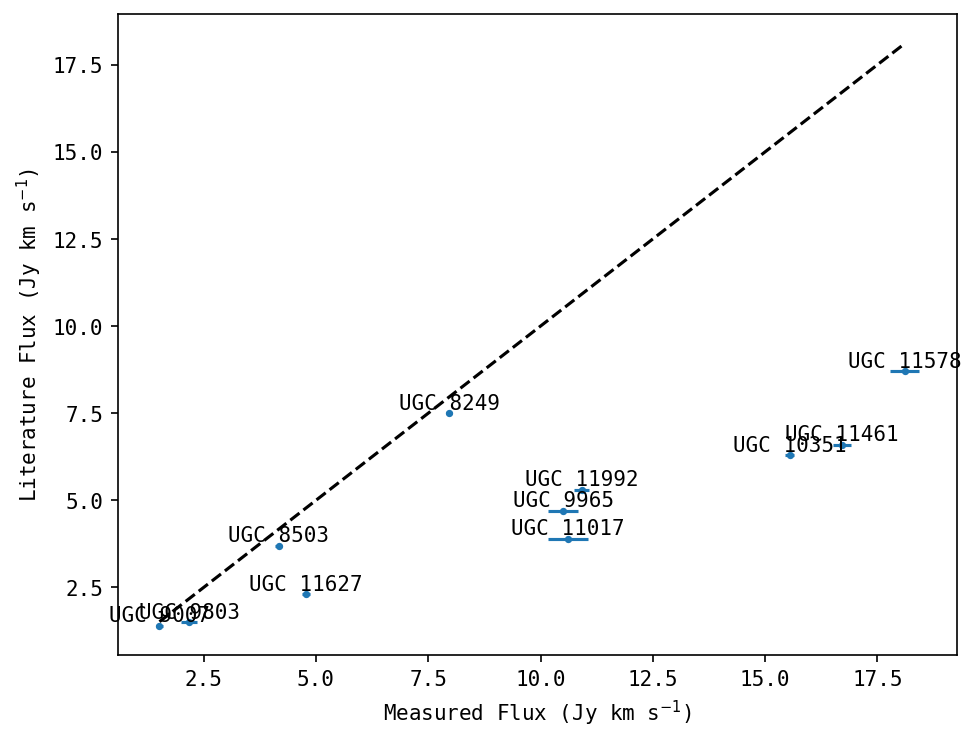

In [61]:
plt.figure(dpi=150)
# Plot a 1-to-1 line using the observed values.
plt.plot(sorted(df_obs_s["flux"]), sorted(df_obs_s["flux"]), "k--")
plt.errorbar(df_obs_s["flux"], df_lit_s["flux"], 
             xerr=df_obs_s["flux_error"], 
             yerr=df_lit_s["flux_error"], 
             marker=".", ls="", ms=5)
for n,o,l in zip(df_obs_s["name"], df_obs_s["flux"], df_lit_s["flux"]):
    plt.text(o, l, n, ha="center", va="bottom")
plt.tight_layout()
plt.xlabel("Measured Flux (Jy km s$^{-1}$)")
plt.ylabel("Literature Flux (Jy km s$^{-1}$)");

There are significant differences between the tabulated values and those measured from this data set.
At the time of writing we do not understand the origin of the difference. As far as we can tell, processing the data in GBTIDL produces equivalent results as those presented here (the differences in flux measurements are <1 Jy km s$^{-1}$). Stay tuned for an update.

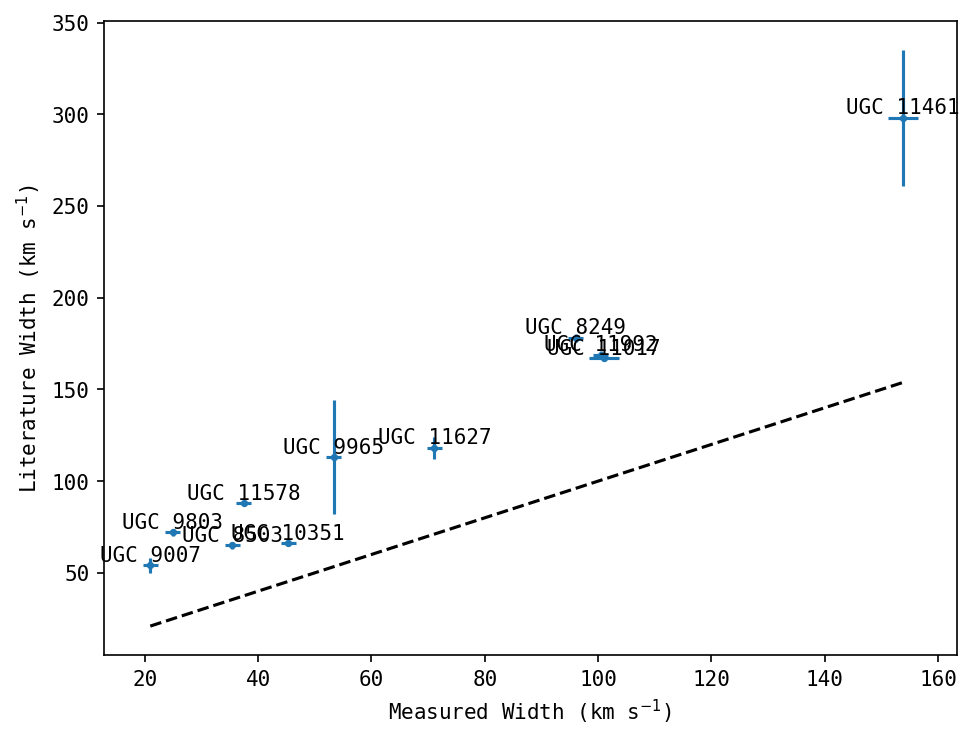

In [62]:
plt.figure(dpi=150)
# Plot a 1-to-1 line using the observed values.
plt.plot(sorted(df_obs_s["width"]*2), sorted(df_obs_s["width"]*2), "k--")
plt.errorbar(df_obs_s["width"]*2, df_lit_s["width"], 
             xerr=df_obs_s["width_error"], 
             yerr=df_lit_s["width_error"], 
             marker=".", ls="", ms=5)
for n,o,l in zip(df_obs_s["name"], df_obs_s["width"]*2, df_lit_s["width"]):
    plt.text(o, l, n, ha="center", va="bottom")
plt.tight_layout()
plt.xlabel("Measured Width (km s$^{-1}$)")
plt.ylabel("Literature Width (km s$^{-1}$)");

There is a $\sim30$ km s$^{-1}$ offset between the widths measured here and the tabulated ones. Again, we do not understand why.